In [1]:
# Here evaluate 0-shot reference mapping on an internal (Allen Institute) human brain dataset. 
# notebook has been cleaned up, needs to be re-run (~1 hour run time).

In [2]:
from pathlib import Path
import warnings
import subprocess
import sys

import numpy as np
import pandas as pd
from scipy.stats import mode
import scanpy as sc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
from rich import print as rprint  
from schelp.utils.config import load_config
from schelp.utils.data import donor_split

import matplotlib.pyplot as plt
import seaborn as sns

import torchtext
torchtext.disable_torchtext_deprecation_warning()

import scgpt as scg
import faiss


custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/scGPT/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/scGPT/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [3]:
paths = load_config(dataset_key="init")
subprocess.run(["tree", "-L", "1", paths["data"]])
subprocess.run(["tree", "-L", "1", paths["pretrained_models"]])

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/datasets
├── COVID-19-splitted
├── Human-Brain
├── Lung-Kim-splitted
├── ms
└── results

6 directories, 0 files
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/pretrained_models
├── scGPT_CP
├── scGPT_brain
└── scGPT_human

4 directories, 0 files


CompletedProcess(args=['tree', '-L', '1', PosixPath('/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/pretrained_models')], returncode=0)

We set the columns storing gene name columns, batch key and cell type key.

In [5]:
# data_dir = str(paths["data"])
# adata = sc.read_h5ad(str(paths["data"]) + '/Human-Brain/train_rna_geneformer.h5ad', backed="r")

from schelp.utils.config import load_config
from rich import print as rprint
import pandas as pd


paths = load_config(dataset_key="init")

def load_dataset_balance(paths, seed=0):

    data_dir = str(paths["data"])
    adata_ = sc.read_h5ad(str(paths["data"]) + '/Human-Brain/balanced_SEAAD_MTG_RNAseq_Singleome_final-nuclei.2024-06-18.h5ad')
    adata_.obs["celltype"] = adata_.obs["Supertype"]
    adata_.obs["batch"] = adata_.obs["Donor ID"]

    num_types = adata_.obs["celltype"].unique().size
    id2type = dict(enumerate(adata_.obs["celltype"].cat.categories))
    celltypes = adata_.obs["celltype"].unique()
    celltype_id_labels = adata_.obs["celltype"].astype("category").cat.codes.values
    adata_.obs["celltype_id"] = celltype_id_labels
    adata_.obs["batch_id"] = adata_.obs["batch"].cat.codes.values
    adata_.var["gene_name"] = adata_.var.index.tolist()
    
    # get high variance genes
    sc.pp.highly_variable_genes(adata_, n_top_genes=4000, flavor="cell_ranger", batch_key="batch")
    adata_ = adata_[:, adata_.var["highly_variable"]]
    #adata_ = sc.pp.subsample(adata_, fraction=0.1, copy=True, random_state=seed)
    n_cells = adata_.shape[0]

    # split the data into train and test
    # train_ind, test_ind = train_test_split(range(n_cells), test_size=0.2, random_state=seed)
    train_ind, test_ind = donor_split(obs=adata_.obs, donor_frac_pergroup=0.15)
    adata = adata_[train_ind].to_memory()
    adata_test = adata_[test_ind].to_memory()
    
    del adata_
    print(f"There are {adata.shape[0]} cells in the reference set")
    print(f"There are {adata_test.shape[0]} cells in the query set")

    return adata, adata_test, celltypes, id2type

adata_train, adata_test, celltypes, id2type = load_dataset_balance(paths, seed=0)



/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/schelp/schelp/utils/data.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_supertype_entropy = df.groupby("Donor ID")["Supertype"].apply(entropy).sort_values(ascending=False).to_frame()
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/schelp/schelp/utils/data.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_.groupby("Overall AD neuropathological Change")[df_.columns]
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/schelp/schelp/utils/data.py:51: FutureWarning: The default of observed=Fals

High supertype entropy donors make up 15.18% of total cells
Train set: 84.82%
Test set: 15.18%
There are 117906 cells in the reference set
There are 21094 cells in the query set


In [6]:
cell_type_key = "celltype"
gene_col = "gene_name"

display(adata_train.var[gene_col].to_frame().head(3))
display(adata_train.obs[cell_type_key].to_frame().head(3))

,gene_name
SAMD11,SAMD11
HES4,HES4
MXRA8,MXRA8


,celltype
exp_component_name,
CATCAAGTCGGATACT-L8TX_210729_01_G12-1153814338,Oligo_4
AAGCCATGTGATATAG-LKTX_191204_01_F01-1156636535,Oligo_4
TCGATTTGTCGTGATT-L8TX_210715_01_D05-1153814295,Oligo_4


In [7]:
# n_cells = adata.shape[0]
# train_ind, test_ind = train_test_split(np.arange(n_cells), test_size=0.2, random_state=42)

# train_ind = np.sort(train_ind)
# test_ind = np.sort(test_ind)

# adata_train = adata[train_ind].to_memory()
# adata_test = adata[test_ind].to_memory()

Embed the reference dataset

In [8]:
model_dir =  Path(str(paths["pretrained_models"] / "scGPT_brain"))
ref_embed_adata = scg.tasks.embed_data(
    adata_train,
    model_dir,
    gene_col=gene_col,
    batch_size=128,
)

scGPT - INFO - match 3383/4000 genes in vocabulary of size 60697.


/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/scGPT/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 922/922 [03:46<00:00,  5.03it/s] Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Tracebac

Embed the query dataset

In [9]:
test_embed_adata = scg.tasks.embed_data(
    adata_test,
    model_dir,
    gene_col=gene_col,
    batch_size=128,
)

scGPT - INFO - match 3383/4000 genes in vocabulary of size 60697.


/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/scGPT/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 165/165 [01:02<00:00,  6.08it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceba

Mark the reference vs. query cells and mask the cell types on query cells

In [10]:
# concatenate the two datasets
adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
# mark the reference vs. query dataset
adata_concat.obs["is_ref"] = ["Query"] * len(test_embed_adata) + ["Reference"] * len(
    ref_embed_adata
)
adata_concat.obs["is_ref"] = adata_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].astype("category")
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
adata_concat.obs[cell_type_key][: len(test_embed_adata)] = "To be predicted"

/allen/scratch/aibstemp/rohang/.tmpdir/ipykernel_266070/4201321170.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
/allen/scratch/aibstemp/rohang/.tmpdir/ipykernel_266070/4201321170.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer,

## Visualize the embeddings

In [11]:
# sc.pp.neighbors(adata_concat, use_rep="X_scGPT")
# sc.tl.umap(adata_concat)
# sc.pl.umap(
#     adata_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
# )

## Reference mapping and transfer the annotations

We run the reference mapping using cell-level majority voting. You may adjust the `k` parameter to control the number of nearest neighbors to consider for voting.

In [12]:
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"]
test_emebd = test_embed_adata.obsm["X_scGPT"]

k = 10  # number of neighbors

# Build index
index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
sim_list = distances

In [13]:
# building the index on top of the embeddings takes long - 27 minutes for ~1 800,000 cells. + 200,000 queries. 
# annoy / scann are other fast knn classifier options for majority-vote based class label prediction.

In [14]:
for k in tqdm(idx_list):
    idx = labels[k]
    pred = ref_embed_adata.obs[cell_type_key].iloc[idx].value_counts()
    preds.append(pred.index[0])
gt = adata_test.obs[cell_type_key].to_numpy()

  0%|          | 0/21094 [00:00<?, ?it/s]

100%|██████████| 21094/21094 [00:07<00:00, 2781.95it/s]


## Evaluate the performance

In [15]:
res_dict = {
    "accuracy":  np.round(accuracy_score(gt, preds),3),
    "precision": np.round(precision_score(gt, preds, average="macro"),3),
    "recall":    np.round(recall_score(gt, preds, average="macro"),3),
    "macro_f1":  np.round(f1_score(gt, preds, average="macro"),3),
}

rprint(res_dict)

{'accuracy': 0.677, 'precision': 0.687, 'recall': 0.682, 'macro_f1': 0.679}

Confusion matrix:

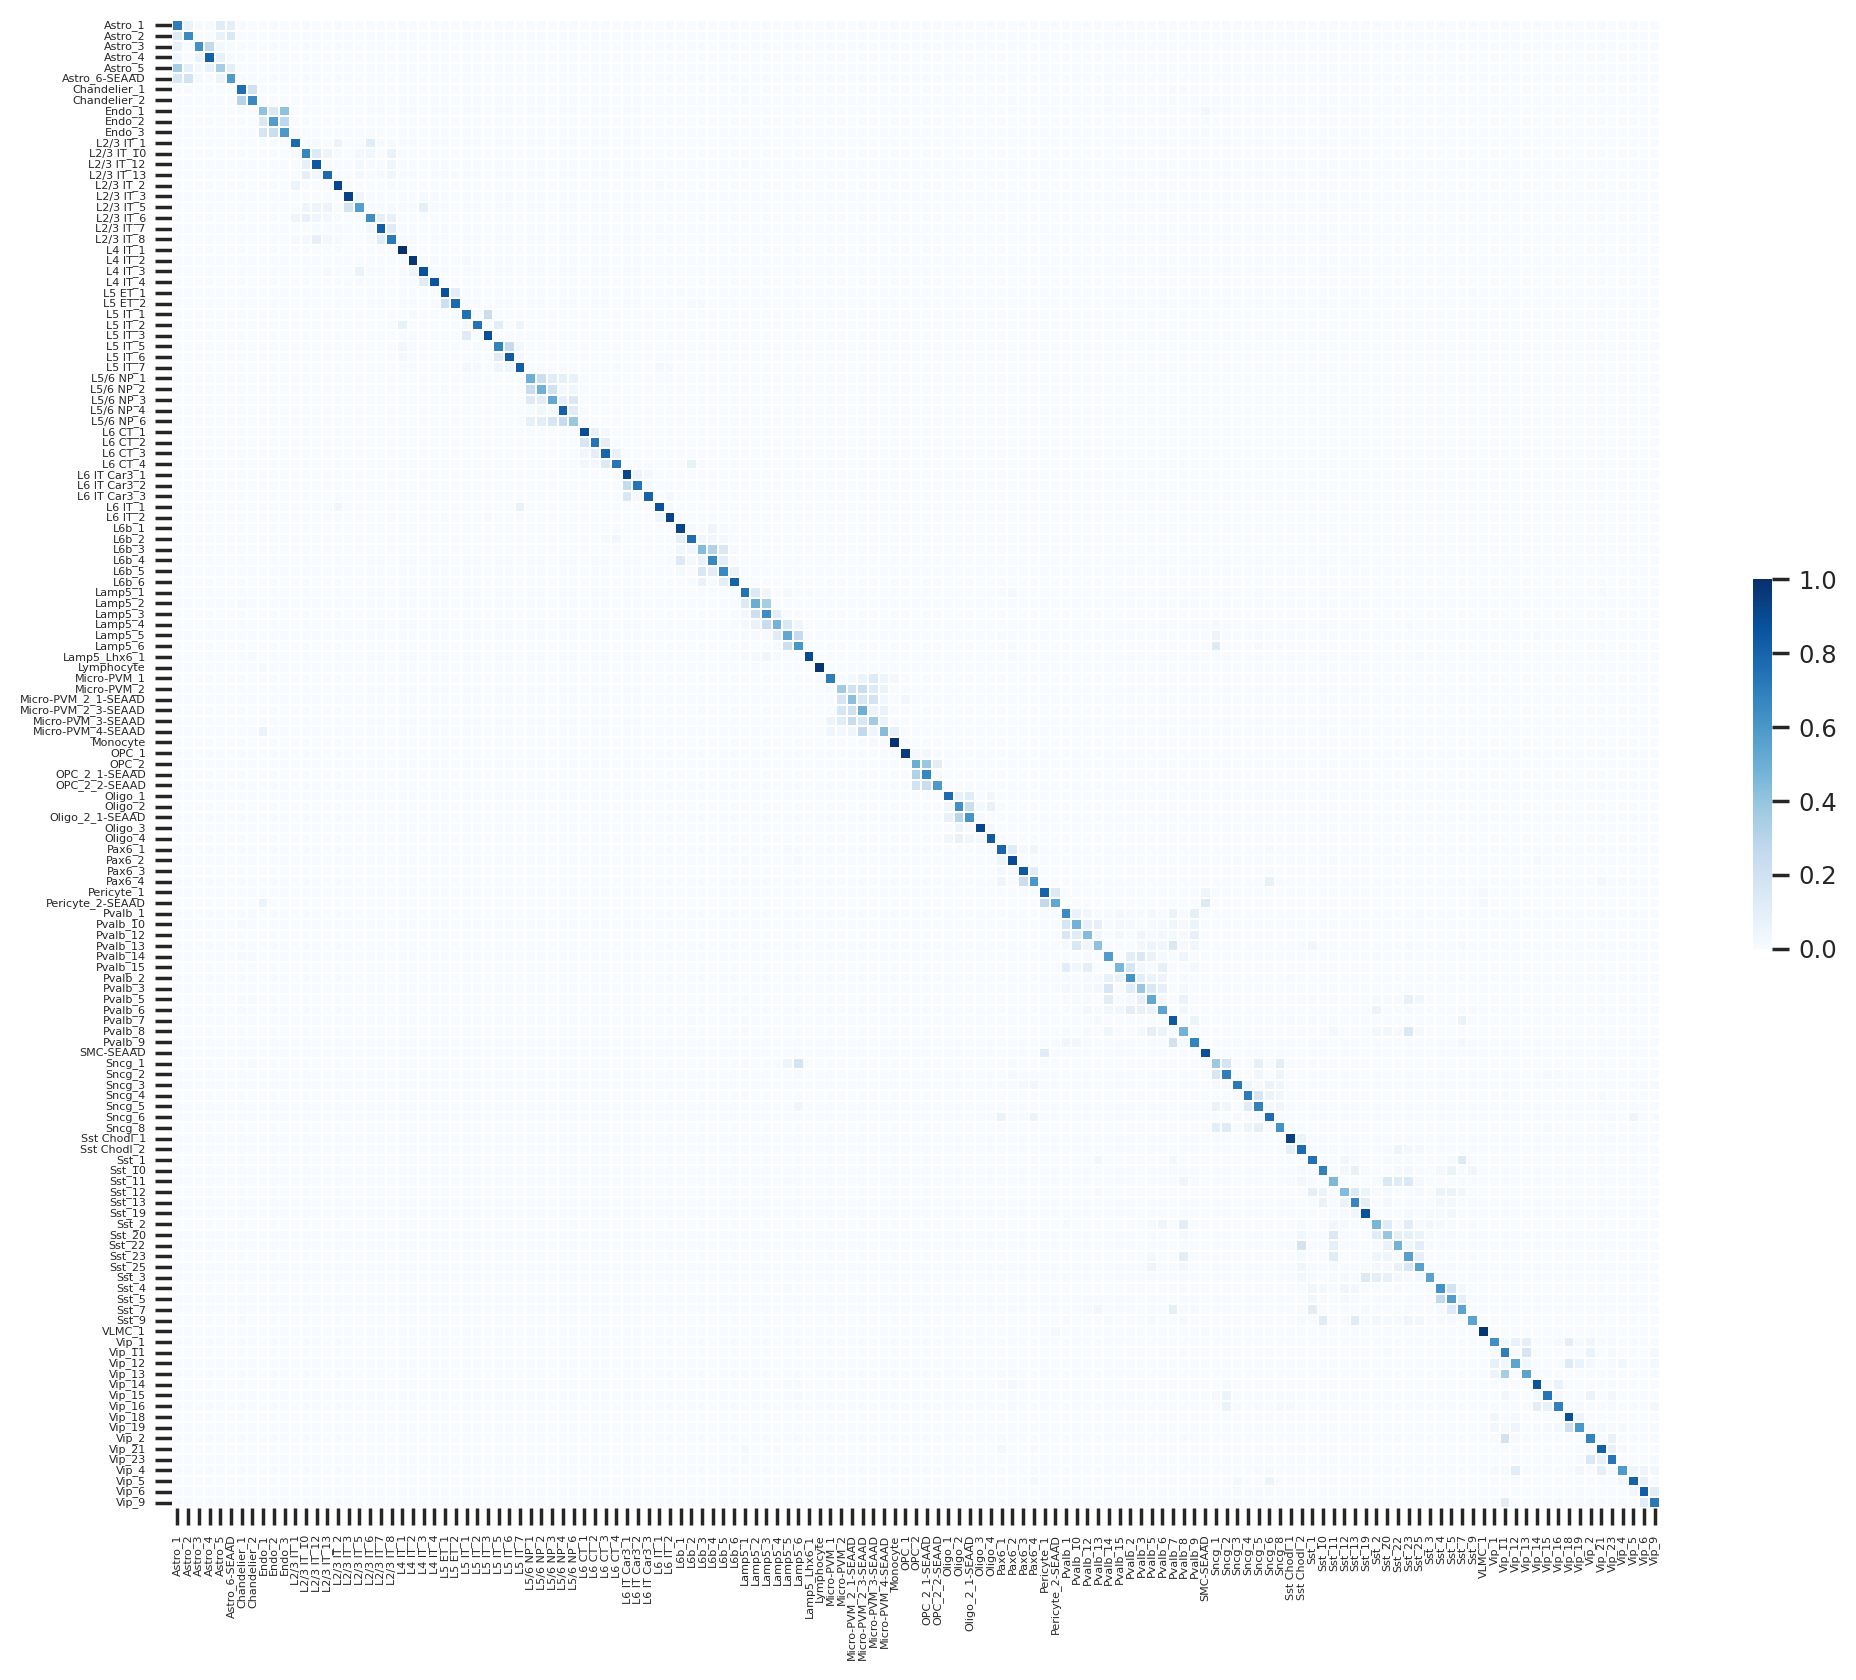

In [16]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(df,  
            cmap='Blues',
            annot=False ,fmt=".2f", 
            annot_kws={'size': 5}, 
            vmin=0, 
            vmax=1,
            ax=ax,
            linewidths=0.1,
            square=True,
            cbar_kws={'shrink': .2},
            xticklabels=1, yticklabels=1)
# reduce font for xticklabels
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)
plt.show()


In [17]:
# get classification report
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=cell_type_list, output_dict=True)
df = pd.DataFrame(report).transpose()
display(df.tail(3))

# display full dataframe
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# reorder rows to match the order of celltypes
df = df.reindex(cell_type_list)

# color any values less than 0.5
def color_negative_red(val):
    color = '#ff9999' if val < 0.5 else 'black'
    return 'color: %s' % color

display(df.round(3).style.applymap(color_negative_red))


,precision,recall,f1-score,support
accuracy,0.677159,0.677159,0.677159,0.677159
macro avg,0.686653,0.681761,0.679002,21094.000000
weighted avg,0.685789,0.677159,0.676178,21094.000000


/allen/scratch/aibstemp/rohang/.tmpdir/ipykernel_266070/1970544275.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(df.round(3).style.applymap(color_negative_red))


,precision,recall,f1-score,support
Astro_1,0.524000,0.703000,0.600000,172.000000
Astro_2,0.681000,0.649000,0.664000,151.000000
Astro_3,0.888000,0.627000,0.735000,177.000000
Astro_4,0.592000,0.811000,0.684000,111.000000
Astro_5,0.528000,0.352000,0.423000,159.000000
Astro_6-SEAAD,0.529000,0.589000,0.558000,107.000000
Chandelier_1,0.696000,0.760000,0.727000,196.000000
Chandelier_2,0.740000,0.660000,0.698000,194.000000
Endo_1,0.504000,0.411000,0.453000,146.000000
Endo_2,0.667000,0.576000,0.618000,184.000000


In [18]:
import pickle
save_dict = {
    "predictions": y_pred,
    "labels": y_true,
    "report": df,
}
with open(paths["data"] / "results/0_shot_ref_mapping_donors.pkl", "wb") as f:
    pickle.dump(save_dict, f)